The goal of this notebook is to produce a few visuals illustrating how Gaussian Process Regression (GPR) works in python.

**Conclusions**:
* Only a GP with noise assumption is able to work with technical repeats.
* Significant improvements in fit observed when technical repeats are introduced.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from src.helpers import gausian_helper

<Axes: >

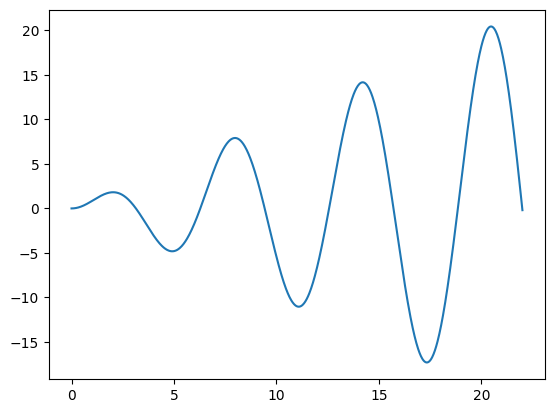

In [2]:
X = np.linspace(start=0, stop=22, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))
sns.lineplot(x=X.ravel(), y=y)

# Just the kernel

#### Train test sample

In [3]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=10, replace=False)
X_train, y_train = X[training_indices], y[training_indices]
X_train

array([[11.16516517],
       [18.01401401],
       [ 9.95395395],
       [ 8.1041041 ],
       [ 5.32932933],
       [20.45845846],
       [ 5.76976977],
       [17.83783784],
       [ 7.003003  ],
       [ 1.07907908]])

## No noise gaussian

In [4]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

13.4**2 * RBF(length_scale=2.12)

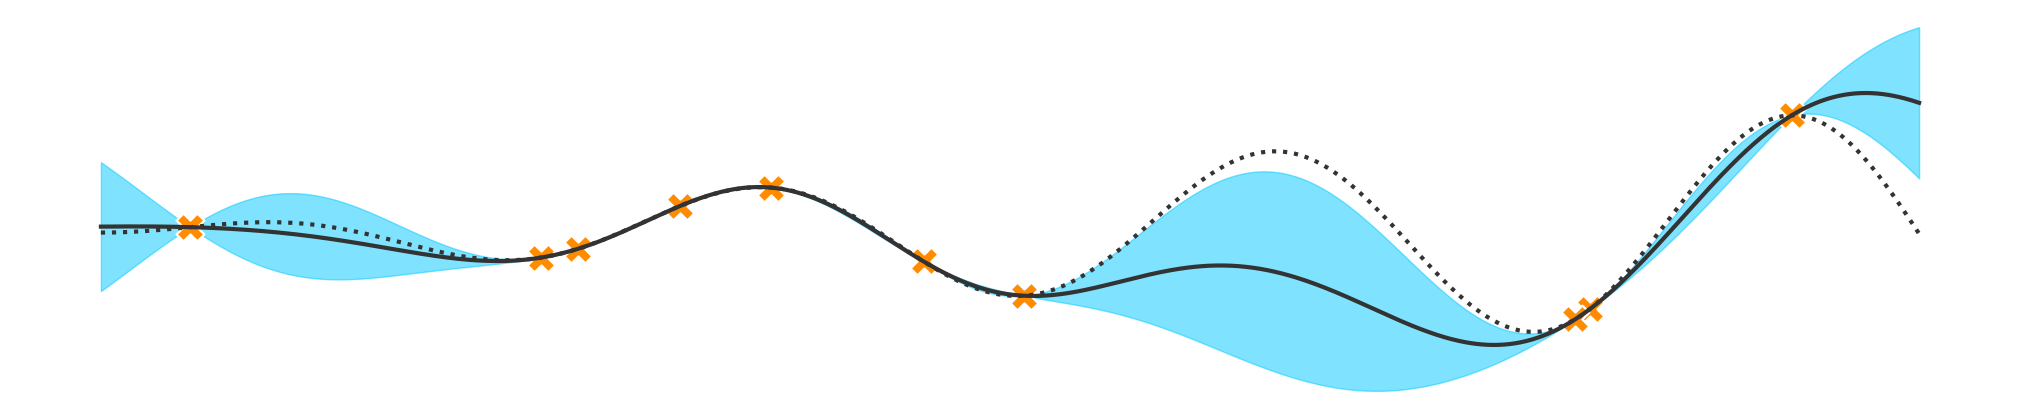

In [36]:

import numpy as np
from matplotlib import pyplot as plt
from openpyxl.drawing import line
from sklearn.gaussian_process import GaussianProcessRegressor
import seaborn as sns
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd


def local_plot_gp(gp:GaussianProcessRegressor, X:np.array, y:np.array, X_train:np.array, y_train:np.array):
    gp.fit(X_train, y_train)
    mean_prediction, std_prediction = gp.predict(X, return_std=True)


    plt.plot(X, mean_prediction, label="Mean prediction", color='#333333', linewidth=3)
    plt.fill_between(
        X.ravel(),
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        alpha=0.5,
        label=r"95% confidence interval",
        color='#00C8FF'
 
    )

    sns.scatterplot(x=X_train.ravel(), y=y_train, marker='X', color='#FF8B00', label='Noisy Observations', s=400)

    plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted", color='#333333', linewidth=3)


    fig = plt.gcf()
    return fig

#colors = utils.theme_branding.BRAND_COLOURS
fig = local_plot_gp(gaussian_process, X, y, X_train, y_train)


ax = fig.axes[0]
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
    ax.legend_.remove() if ax.legend_ else None
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.suptitle('')
    ax.set_title('')
    # If savefig is not working, try explicitly creating the directory if it doesn't exist
import os
output_dir = "images"
os.makedirs(output_dir, exist_ok=True)

fig.set_size_inches(20, 4)

fig.savefig(os.path.join(output_dir, "dry-lab-banner.png"), dpi=800, bbox_inches=None)


We can see the prediction failing at the boundaries, but simple function can be near perfectly fit given some resolution.

## Noise and resampling
The sklearn implementation accepts a constant as variance of Gaussian noise. i.e. it is unable to adjust to the magnitude of sampled noise directly, and is thus not suitable for our applications.

#### Homoscedastic noise

In [6]:
y_train_noisy = y_train +4*np.random.randn(y_train.size)
y_train_noisy

array([ -8.5044208 , -20.56760422,  -1.76783487,   7.96022552,
         1.19709077,  25.65069499, -11.16501009, -12.2490893 ,
         3.07344987,   4.12886152])

Text(0.5, 1.0, 'Gaussian Process Regression with Noisy Observations')

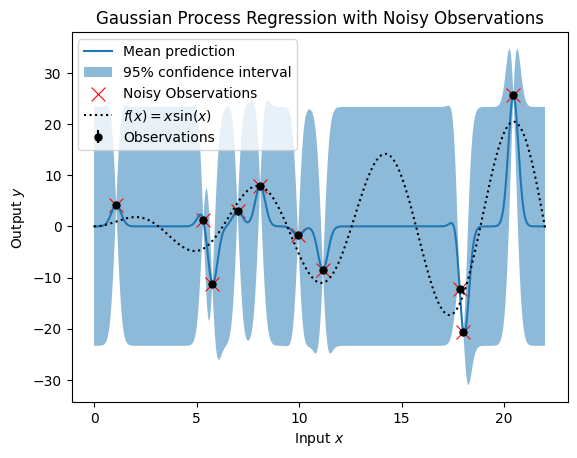

In [7]:
gausian_helper.plot_gp(gaussian_process, X, y, X_train, y_train_noisy)
plt.title("Gaussian Process Regression with Noisy Observations")

* Noise has significant effect on the process. However, the general trends appear to be maintained

### Noise kernel

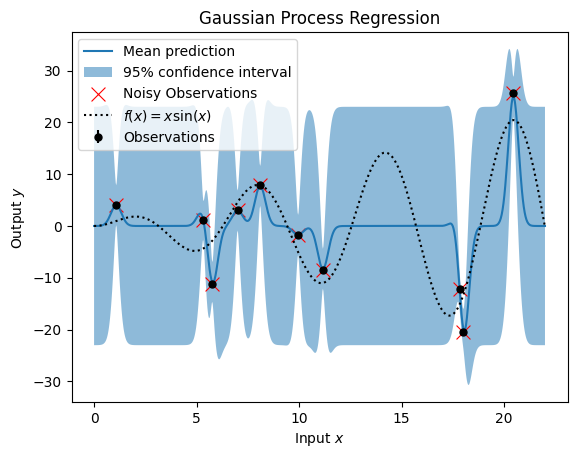

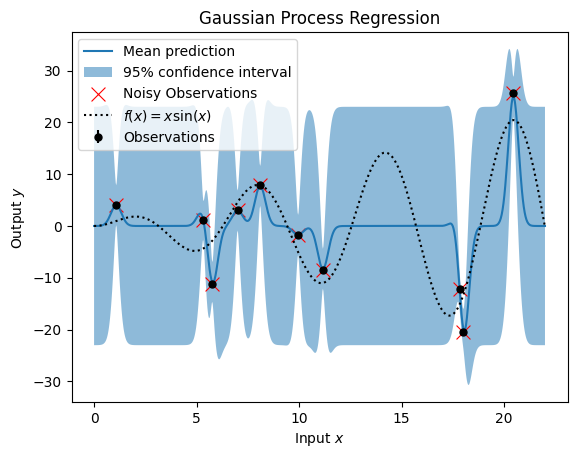

In [8]:
noisy_gp = GaussianProcessRegressor(kernel=kernel, alpha=4, n_restarts_optimizer=9)
noisy_gp.fit(X_train, y_train_noisy)
noisy_gp.kernel_  # Note the increased length scale
gausian_helper.plot_gp(noisy_gp, X, y, X_train, y_train_noisy)

Adding a noise kernel significantly reduces noise overfiting.

### Technical repeats

In [9]:

X_tech = np.append(X_train,X_train, axis=0)
y_tech = np.append(y_train,y_train, axis=0)
y_tech_noisy = y_tech +4*np.random.randn(np.size(y_tech))
y_tech_noisy.shape

(20,)

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-iSV9AhHi-py3.11\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge after 2 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-iSV9AhHi-py3.11\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning:

lbfgs failed to converge after 0 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-iSV9AhHi-py3.11\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit

Text(0.5, 1.0, 'Gaussian Process Regression with Noisy Observations')

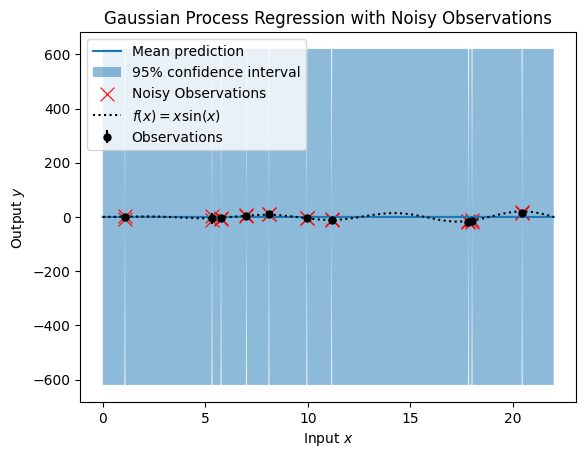

In [10]:
import importlib
importlib.reload(gausian_helper)
gausian_helper.plot_gp(gaussian_process, X, y, X_tech, y_tech_noisy)
plt.title("Gaussian Process Regression with Noisy Observations")

* This model is incapable of handling technical repeats - gradient changes at the same location are not captured.
* A noise Kernel is necessary to handle technical repeats. 

<Axes: title={'center': 'Gaussian Process Regression with Noisy Observations'}, xlabel='Input $x$', ylabel='Output $y$'>

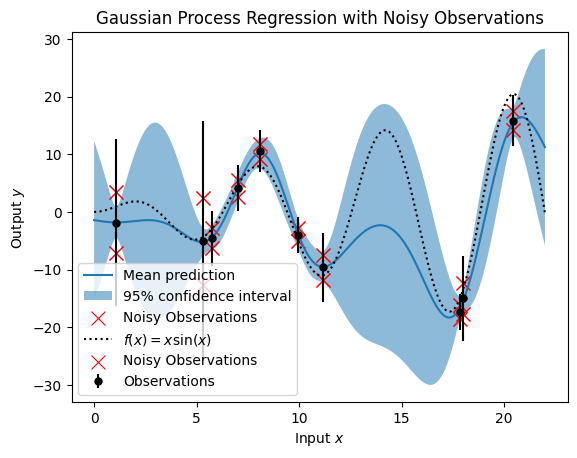

In [11]:
noisy_gp = GaussianProcessRegressor(kernel=kernel, alpha=4, n_restarts_optimizer=9)

gausian_helper.plot_gp(noisy_gp, X, y, X_tech, y_tech_noisy)
plt.title("Gaussian Process Regression with Noisy Observations")
sns.scatterplot(x=X_tech.ravel(), y=y_tech_noisy, marker='x', color='r', label='Noisy Observations', s=100)

Technical repeats significantly improve performance, but only if the GP is able to capture noise.